In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report

from sklearn.svm import LinearSVC

from sklearn.linear_model import LogisticRegression

from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

Unificazione di tutti i file .csv in un'unica variabile data

In [ ]:
# percorso base della cartella che contiene i CSV
base_dir = Path(
    r"C:\Users\nicde\OneDrive\Desktop\Università\Ancona\DS\Data-Science\datasets"
) / "archive"

# elenco ordinato di tutti i file CSV
csv_files = sorted(base_dir.glob("*.csv"))

print(f"Numero di file CSV trovati: {len(csv_files)}")

dfs = []

# lettura sequenziale dei CSV
for i, file in enumerate(csv_files, 1):
    print(f"Caricamento file {i}/{len(csv_files)} → {file.name}")
    df = pd.read_csv(file, low_memory=False)
    dfs.append(df)

# concatenazione row-wise
data = pd.concat(dfs, ignore_index=True)

# controlli rapidi
data.head()

Numero di file CSV trovati: 7
Caricamento file 1/7 → CEAS_08.csv
Caricamento file 2/7 → Enron.csv
Caricamento file 3/7 → Ling.csv
Caricamento file 4/7 → Nazario.csv
Caricamento file 5/7 → Nigerian_Fraud.csv
Caricamento file 6/7 → phishing_email.csv
Caricamento file 7/7 → SpamAssasin.csv


,sender,receiver,date,subject,body,label,urls,text_combined
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1.0,NaN
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1.0,NaN
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1.0,NaN
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1.0,NaN
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1.0,NaN


Pre processing verso la classificazione

In [5]:
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164972 entries, 0 to 164971
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sender         49529 non-null   object 
 1   receiver       47768 non-null   object 
 2   date           49377 non-null   object 
 3   subject        82139 non-null   object 
 4   body           82485 non-null   object 
 5   label          164972 non-null  int64  
 6   urls           49860 non-null   float64
 7   text_combined  82486 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 10.1+ MB


Index(['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls',
       'text_combined'],
      dtype='object')

label
1    85782
0    79190
Name: count, dtype: int64


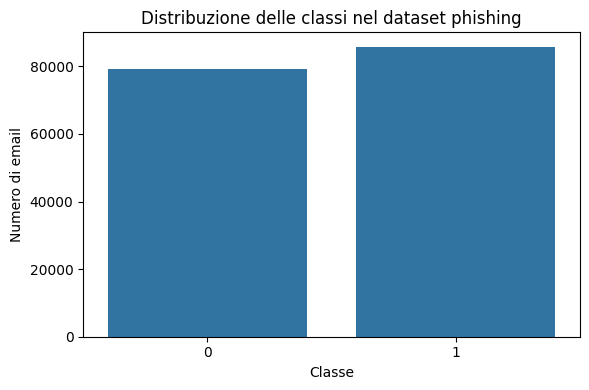

In [6]:
print(data["label"].value_counts())
category_counts = data["label"].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(
    x=category_counts.index,
    y=category_counts.values
)

plt.xlabel("Classe")
plt.ylabel("Numero di email")
plt.title("Distribuzione delle classi nel dataset phishing")

plt.tight_layout()
plt.show()

In [7]:
# rimozione duplicati
data.drop_duplicates(inplace=True)

# rimozione righe con testo mancante
data = data.dropna(subset=["body"])   
print(data["label"].value_counts())

label
1    42890
0    39595
Name: count, dtype: int64


In [8]:
# Creazione della colonna di testo combinato subject + body
data["text_combined"] = (
    data["subject"].fillna("").astype(str) + " " + data["body"].fillna("").astype(str)
).str.strip()

# rimuove righe completamente vuote dopo la concatenazione
data = data[data["text_combined"].str.len() > 0].copy()


# Regex precompilate
URL_RE = re.compile(r"(https?://[^\s]+|www\.[^\s]+)")
EMAIL_RE = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")
NUM_RE = re.compile(r"\b\d+(\.\d+)?\b")
HTML_RE = re.compile(r"<[^>]+>")


# Funzione di pulizia del testo
def clean_email_text(text) -> str:
    if pd.isna(text):
        return ""
    text = str(text).lower()

    # Rimuove tag HTML
    text = HTML_RE.sub(" ", text)

    # Normalizza URL, Email e Numeri
    text = URL_RE.sub(" __URL__ ", text)
    text = EMAIL_RE.sub(" __EMAIL__ ", text)
    text = NUM_RE.sub(" __NUM__ ", text)

    # Pulizia spazi
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Feature numeriche per conteggio URL ed email a fine di visualizzazione
data["num_urls"] = data["text_combined"].apply(lambda x: len(URL_RE.findall(x)))
data["num_emails"] = data["text_combined"].apply(lambda x: len(EMAIL_RE.findall(x)))


# Creazione colonna testo pulito
data["text_clean"] = data["text_combined"].apply(clean_email_text)

# Check finale
print("NaN in text_combined:", data["text_combined"].isna().sum())
print("Righe totali:", len(data))
print(data[["text_combined", "text_clean", "num_urls", "num_emails", "label"]].head())


NaN in text_combined: 0
Righe totali: 82485
                                       text_combined  ... label
0  Never agree to be a loser Buck up, your troubl...  ...     1
1  Befriend Jenna Jameson \nUpgrade your sex and ...  ...     1
2  CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...  ...     1
3  Re: svn commit: r619753 - in /spamassassin/tru...  ...     0
4  SpecialPricesPharmMoreinfo \nWelcomeFastShippi...  ...     1

[5 rows x 5 columns]


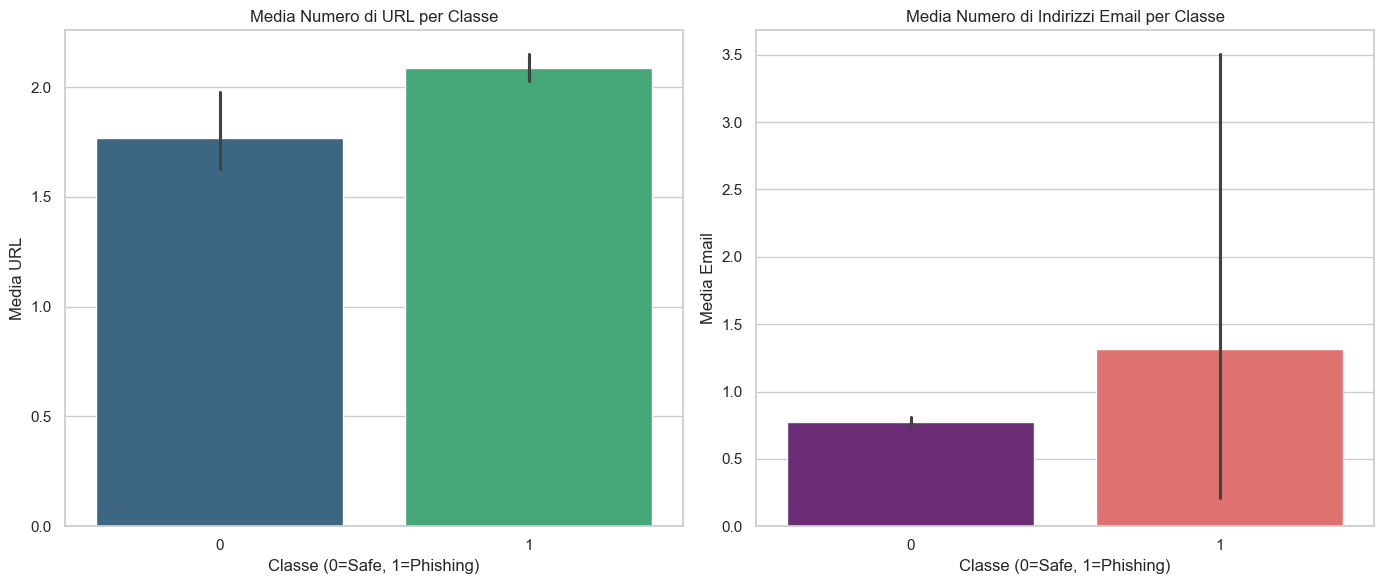

Valori medi per classe:
       num_urls  num_emails
label                      
0      1.768961    0.776866
1      2.086967    1.312217


In [9]:
# Impostiamo lo stile
sns.set_theme(style="whitegrid")

# Creiamo una figura con due grafici affiancati
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grafico per il numero di URL
sns.barplot(
    data=data, 
    x='label', 
    y='num_urls', 
    ax=axes[0], 
    palette='viridis',
    estimator='mean' # Mostra la media
)
axes[0].set_title('Media Numero di URL per Classe')
axes[0].set_xlabel('Classe (0=Safe, 1=Phishing)')
axes[0].set_ylabel('Media URL')

# Grafico per il numero di Email
sns.barplot(
    data=data, 
    x='label', 
    y='num_emails', 
    ax=axes[1], 
    palette='magma',
    estimator='mean'
)
axes[1].set_title('Media Numero di Indirizzi Email per Classe')
axes[1].set_xlabel('Classe (0=Safe, 1=Phishing)')
axes[1].set_ylabel('Media Email')

plt.tight_layout()
plt.show()

# Stampa anche i valori numerici
print("Valori medi per classe:")
print(data.groupby('label')[['num_urls', 'num_emails']].mean())

NAIVE BAYES

In [10]:
X = data["text_clean"]
y = data["label"]

# Split stratificato
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Pipeline: TF-IDF -> NB
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2
    )),
    ("nb", ComplementNB()) 
])

# Grid Search su alpha
param_grid = {
    "nb__alpha": [0.1, 0.5, 1.0, 5.0, 10.0]
}

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",     
    n_jobs=-1
)

grid.fit(X_train, y_train)

print(f"🔹 Miglior alpha trovato: {grid.best_params_['nb__alpha']}")
print(f"🔹 Miglior score CV (f1_macro): {grid.best_score_:.4f}")

# Test set evaluation
y_pred = grid.predict(X_test)

print("🔹 Naive Bayes Performance (Test):")
print(classification_report(y_test, y_pred, digits=4))


🔹 Miglior alpha trovato: 0.1
🔹 Miglior score CV (f1_macro): 0.9866
🔹 Naive Bayes Performance (Test):
              precision    recall  f1-score   support

           0     0.9808    0.9948    0.9878      7919
           1     0.9952    0.9820    0.9886      8578

    accuracy                         0.9882     16497
   macro avg     0.9880    0.9884    0.9882     16497
weighted avg     0.9883    0.9882    0.9882     16497



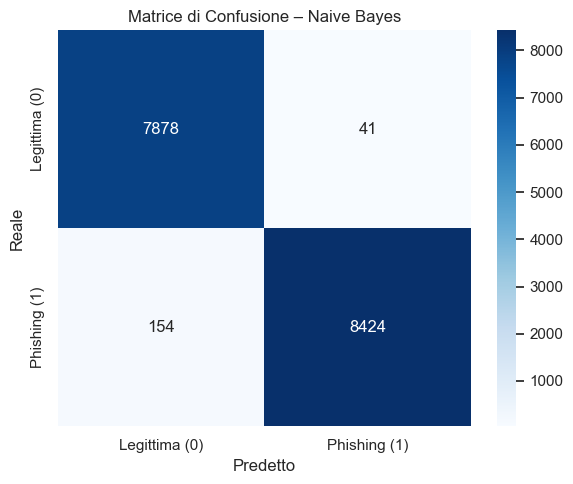

In [11]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Legittima (0)", "Phishing (1)"],
    yticklabels=["Legittima (0)", "Phishing (1)"]
)

plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione – Naive Bayes")
plt.tight_layout()
plt.show()


LOGISTIC REGRESSION

In [12]:
X = data["text_clean"]
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=2)),
    ("lr", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        solver="liblinear"   # stabile su dataset medio e binario
    ))
])

param_grid = {
    "lr__C": [0.1, 0.5, 1, 2, 5, 10]
}

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print(f"🔹 Miglior C trovato: {grid_lr.best_params_['lr__C']}")
print(f"Scoring CV (f1_macro): {grid_lr.best_score_:.4f}")

y_pred_lr = grid_lr.predict(X_test)

print("🔹 Logistic Regression Performance (Test):")
print(classification_report(y_test, y_pred_lr, digits=4))

🔹 Miglior C trovato: 10
Scoring CV (f1_macro): 0.9897
🔹 Logistic Regression Performance (Test):
              precision    recall  f1-score   support

           0     0.9909    0.9913    0.9911      7919
           1     0.9920    0.9916    0.9918      8578

    accuracy                         0.9915     16497
   macro avg     0.9914    0.9914    0.9914     16497
weighted avg     0.9915    0.9915    0.9915     16497



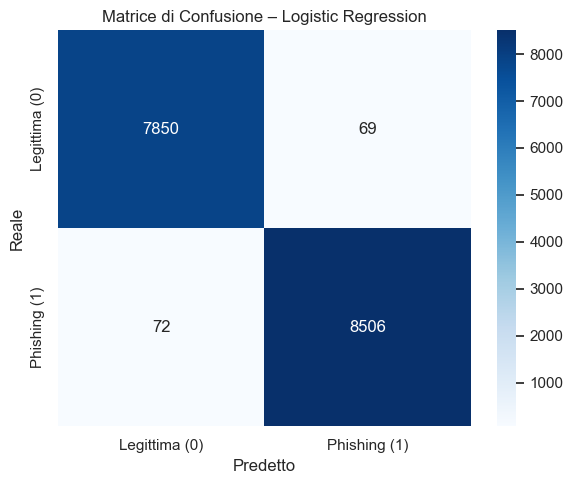

In [13]:
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Legittima (0)", "Phishing (1)"],
    yticklabels=["Legittima (0)", "Phishing (1)"]
)
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione – Logistic Regression")
plt.tight_layout()
plt.show()


SVM

In [ ]:
X = data["text_clean"]
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Pipeline: TF-IDF -> SVM lineare
pipe_svm = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=2)),
    ("svm", LinearSVC(class_weight="balanced", random_state=42))
])

# Grid Search sul parametro di regolarizzazione C
param_grid = {
    "svm__C": [0.1, 0.5, 1, 2, 5, 10]
}

grid_svm = GridSearchCV(
    pipe_svm,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",   
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)

print(f"🔹 Miglior C trovato: {grid_svm.best_params_['svm__C']}")
print(f"🔹 Miglior score CV (f1_macro): {grid_svm.best_score_:.4f}")

# Test set
y_pred_svm = grid_svm.predict(X_test)

print("🔹 SVM (Linear) Performance (Test):")
print(classification_report(y_test, y_pred_svm, digits=4))

🔹 Miglior C trovato: 10
🔹 Miglior score CV (f1_macro): 0.9922
🔹 SVM (Linear) Performance (Test):
              precision    recall  f1-score   support

           0     0.9932    0.9932    0.9932      7919
           1     0.9937    0.9937    0.9937      8578

    accuracy                         0.9935     16497
   macro avg     0.9934    0.9934    0.9934     16497
weighted avg     0.9935    0.9935    0.9935     16497



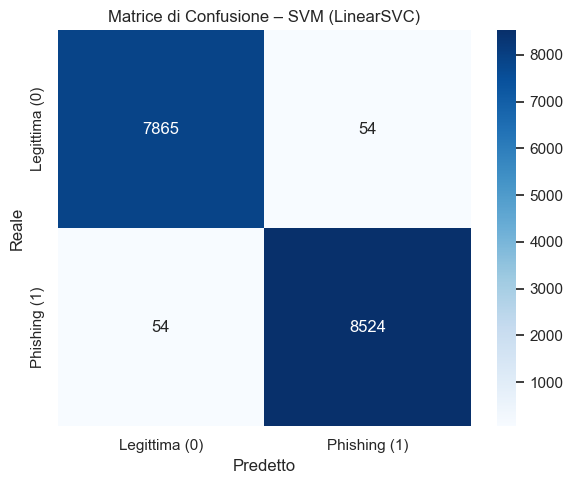

In [ ]:
# Confusion matrix 
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Legittima (0)", "Phishing (1)"],
    yticklabels=["Legittima (0)", "Phishing (1)"]
)
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione – SVM (LinearSVC)")
plt.tight_layout()
plt.show()

WORD2VEC

In [ ]:
# Testo pulito e label
df = data[["text_clean", "label"]].copy()
df["text_clean"] = df["text_clean"].fillna("").astype(str)

X_text = df["text_clean"]
y = df["label"].values

# Tokenizzazione 
TOKEN_RE = re.compile(r"\b\w+\b", re.UNICODE)

def tokenize(text: str):
    return TOKEN_RE.findall(text)

sentences = X_text.map(tokenize).tolist()


# Addestramento Word2Vec sul corpus
w2v = Word2Vec(
    sentences=sentences,
    vector_size=200,  # dimensione embedding
    window=5,
    min_count=2,      # ignora token troppo rari
    workers=4,
    sg=1,             # 1=skip-gram 
    epochs=10
)

vector_size = w2v.vector_size


# Vettori documento (media dei vettori parola)
def doc_vector(tokens, model, vector_size):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    if not vecs:
        return np.zeros(vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

X_emb = np.vstack([doc_vector(tokens, w2v, vector_size) for tokens in sentences])



X_train, X_test, y_train, y_test = train_test_split(
    X_emb, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


lr = LogisticRegression(
    class_weight="balanced",
    max_iter=2000,
    solver="liblinear"
)

param_grid = {"C": [0.1, 0.5, 1, 2, 5, 10]}

grid = GridSearchCV(
    lr,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print(f"🔹 Miglior C trovato: {grid.best_params_['C']}")
print(f"🔹 Miglior score CV (f1_macro): {grid.best_score_:.4f}")

y_pred = grid.predict(X_test)

print("🔹 Word2Vec + Logistic Regression Performance (Test):")
print(classification_report(y_test, y_pred, digits=4))

🔹 Miglior C trovato: 5
🔹 Miglior score CV (f1_macro): 0.9699
🔹 Word2Vec + Logistic Regression Performance (Test):
              precision    recall  f1-score   support

           0     0.9690    0.9686    0.9688      7919
           1     0.9710    0.9714    0.9712      8578

    accuracy                         0.9701     16497
   macro avg     0.9700    0.9700    0.9700     16497
weighted avg     0.9701    0.9701    0.9701     16497



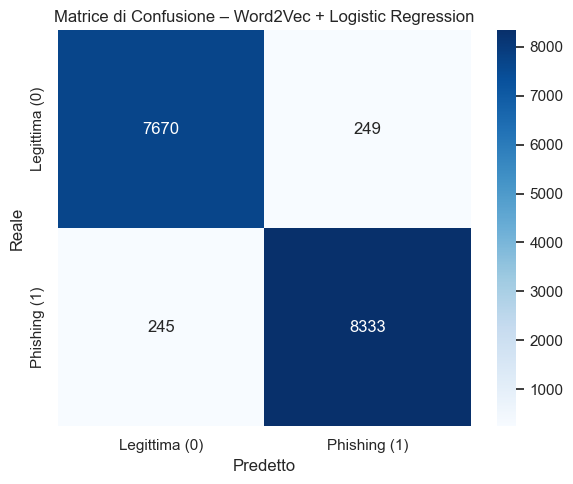

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Legittima (0)", "Phishing (1)"],
    yticklabels=["Legittima (0)", "Phishing (1)"]
)
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione – Word2Vec + Logistic Regression")
plt.tight_layout()
plt.show()


LSTM

In [ ]:
X = data["text_clean"].fillna("").astype(str).values
y = data["label"].values.astype(np.int32)

# train/test come prima
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# da train ricavo validation (10% del train)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)


In [ ]:
# TextVectorization
max_tokens = 50000
seq_len = 300  # lunghezza massima 

vectorize = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=seq_len
)

# "adatta" il vocabolario sui soli testi di training
vectorize.adapt(X_train)

# Modello
embedding_dim = 128

model = models.Sequential([
    vectorize,  # trasforma stringhe -> sequenze di interi
    layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, mask_zero=True),
    layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")  # binario
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# class_weight 
classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}

# EarlyStopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    class_weight=class_weight  
)


Epoch 1/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 263s 280ms/step - accuracy: 0.9408 - loss: 0.1866 - val_accuracy: 0.9777 - val_loss: 0.0737
Epoch 2/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 258s 278ms/step - accuracy: 0.9756 - loss: 0.0828 - val_accuracy: 0.9830 - val_loss: 0.0588
Epoch 3/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 265s 285ms/step - accuracy: 0.9824 - loss: 0.0591 - val_accuracy: 0.9824 - val_loss: 0.0586
Epoch 4/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 267s 288ms/step - accuracy: 0.9905 - loss: 0.0331 - val_accuracy: 0.9845 - val_loss: 0.0536
Epoch 5/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 269s 289ms/step - accuracy: 0.9933 - loss: 0.0232 - val_accuracy: 0.9501 - val_loss: 0.3481
Epoch 6/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 267s 288ms/step - accuracy: 0.9878 - loss: 0.0449 - val_accuracy: 0.9838 - val_loss: 0.0618
Epoch 7/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 270s 291ms/step - accuracy: 0.9939 - loss: 0.0221 - val_accuracy: 0.9888 - val_loss: 0.0524
Epoch 8/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 270s 291ms/step - accuracy: 0.9937 -

65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step
🔹 Deep Learning (LSTM) Performance (Test):
              precision    recall  f1-score   support

           0     0.9881    0.9830    0.9855      7919
           1     0.9843    0.9890    0.9867      8578

    accuracy                         0.9861     16497
   macro avg     0.9862    0.9860    0.9861     16497
weighted avg     0.9861    0.9861    0.9861     16497



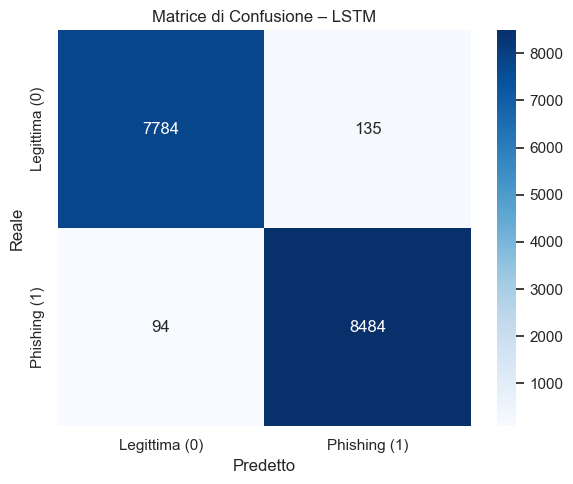

In [ ]:
# Probabilità -> classe (soglia 0.5)
y_prob = model.predict(X_test, batch_size=256).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("🔹 Deep Learning (LSTM) Performance (Test):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Legittima (0)", "Phishing (1)"],
    yticklabels=["Legittima (0)", "Phishing (1)"]
)
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione – LSTM")
plt.tight_layout()
plt.show()


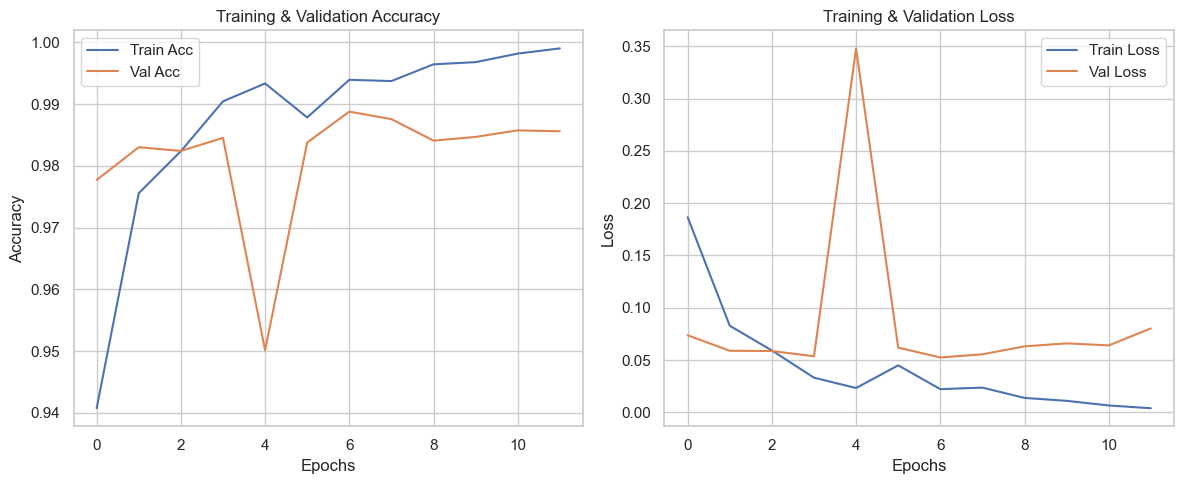

In [21]:
hist = history.history

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(hist["accuracy"], label="Train Acc")
plt.plot(hist["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist["loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


CNN

In [ ]:
# TextVectorization
max_tokens = 50000
seq_len = 300

vectorize = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=seq_len
)
vectorize.adapt(X_train)  # vocabolario solo su training

# CNN model
embedding_dim = 128

cnn_model = models.Sequential([
    vectorize,
    layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, mask_zero=True),

    # Feature extraction (n-gram patterns)
    layers.Conv1D(filters=128, kernel_size=5, activation="relu"),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(filters=128, kernel_size=5, activation="relu"),
    layers.MaxPooling1D(pool_size=2),

    # Aggregazione globale
    layers.GlobalMaxPooling1D(),

    # Classifier head
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

cnn_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# class_weight
classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}

# EarlyStopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    class_weight=class_weight
)

Epoch 1/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 91s 95ms/step - accuracy: 0.9620 - loss: 0.0944 - val_accuracy: 0.9820 - val_loss: 0.0521
Epoch 2/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 87s 94ms/step - accuracy: 0.9942 - loss: 0.0191 - val_accuracy: 0.9868 - val_loss: 0.0450
Epoch 3/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 87s 94ms/step - accuracy: 0.9981 - loss: 0.0065 - val_accuracy: 0.9864 - val_loss: 0.0498
Epoch 4/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 95s 103ms/step - accuracy: 0.9985 - loss: 0.0048 - val_accuracy: 0.9861 - val_loss: 0.0663
Epoch 5/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 100s 108ms/step - accuracy: 0.9987 - loss: 0.0039 - val_accuracy: 0.9829 - val_loss: 0.0703
Epoch 6/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 96s 104ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9783 - val_loss: 0.0958
Epoch 7/20
928/928 ━━━━━━━━━━━━━━━━━━━━ 97s 104ms/step - accuracy: 0.9992 - loss: 0.0025 - val_accuracy: 0.9847 - val_loss: 0.0851


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step
🔹 Deep Learning (CNN) Performance (Test):
              precision    recall  f1-score   support

           0     0.9937    0.9788    0.9862      7919
           1     0.9807    0.9943    0.9874      8578

    accuracy                         0.9868     16497
   macro avg     0.9872    0.9865    0.9868     16497
weighted avg     0.9869    0.9868    0.9868     16497



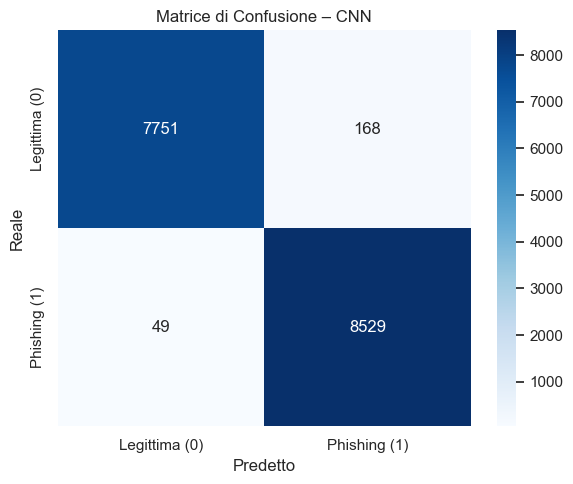

In [24]:
y_prob = cnn_model.predict(X_test, batch_size=256).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("🔹 Deep Learning (CNN) Performance (Test):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Legittima (0)", "Phishing (1)"],
    yticklabels=["Legittima (0)", "Phishing (1)"]
)
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione – CNN")
plt.tight_layout()
plt.show()


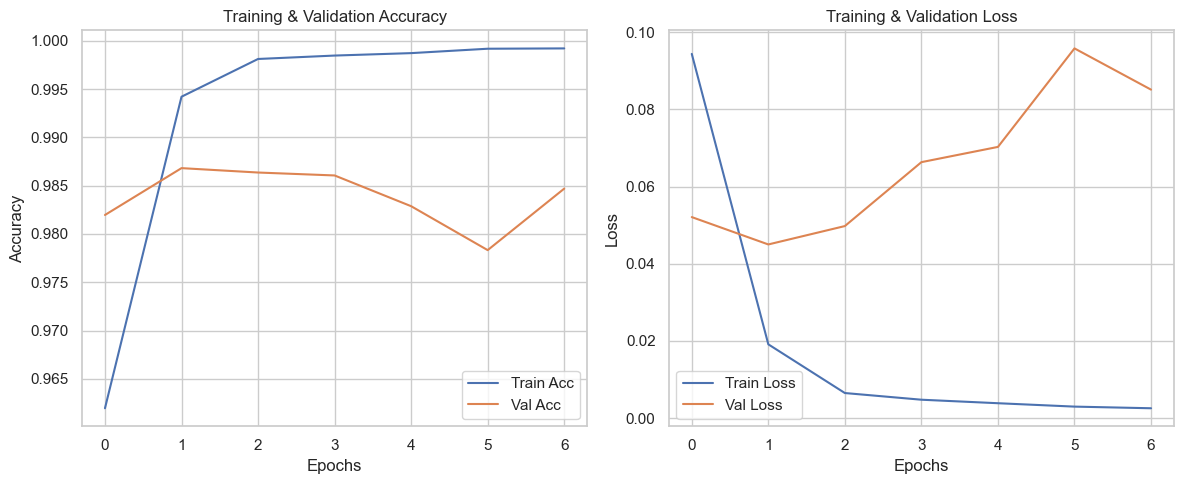

In [25]:
hist = history_cnn.history

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(hist["accuracy"], label="Train Acc")
plt.plot(hist["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist["loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()
